<a href="https://colab.research.google.com/github/davidenko2000/LoFTR_stereo/blob/master/LoFTR_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR evaluation on KITTI dataset

KITTI dataset consists of 200 stereo images (left and right).
Below you can find results of LoFTR matcher on such dataset.


In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
#!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""Method to plot image using real disparity map and computed disparity map"""
def plot_acc_byimage(idx, model):
  real_disp = skimage.util.img_as_ubyte(mpimg.imread(f"/content/drive/MyDrive/data_scene_flow/disparity/{str.zfill(str(idx), 6)}_10.png"))
  real_disp = cv2.resize(real_disp, (1240, 375))
  predicted_disp = compute_disparity_map(idx, model)
  acc = disparity_accuracy_byimage(real_disp=real_disp, predicted_disp=predicted_disp)

  plt.figure(figsize=(20, 10))
  color_map = colors.ListedColormap(['black', 'red', 'yellow'])
  plt.imshow(acc, cmap=color_map)
 

"""
Function which uses real disparity, predicted disparity and pixel error to calcuate accuracy of prediction.
Returns:
        -1 -> if the real disparity is unknown
        0  -> if the prediction in incorrect
        1  -> if the prediction is correct (the prediction must be in the interval which uses allowed pixel error
"""
def disparity_accuracy_byimage(real_disp, predicted_disp, pxl_error=3):
	acc = np.zeros(predicted_disp.shape)
	acc[predicted_disp == 0] = -1
	acc[(predicted_disp != 0) & (np.abs(predicted_disp - real_disp) < pxl_error)] = 1

	return acc

"""
Function which computes disparity map using model and index (idx) of an image.
"""
def compute_disparity_map(idx, model):
  img0_raw = cv2.imread(f"/content/drive/MyDrive/data_scene_flow/RGB/left/{str.zfill(str(idx), 6)}_10.png", cv2.IMREAD_GRAYSCALE)
  img1_raw = cv2.imread(f"/content/drive/MyDrive/data_scene_flow/RGB/right/{str.zfill(str(idx), 6)}_10.png", cv2.IMREAD_GRAYSCALE)
  

  img0_raw = cv2.resize(img0_raw, (1240, 375))
  img1_raw = cv2.resize(img1_raw, (1240, 375))

  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}
  
  predicted_disp = np.zeros(img0_raw.shape)

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()

  for i in range(mkpts0.shape[0]):
    disp = mkpts0[i][0] - mkpts1[i][0] #check only on epipolar line
    predicted_disp[int(mkpts0[i][1])][int(mkpts0[i][0])] = disp

  return predicted_disp


Accuracy on KITTI: 0.18233064980557928


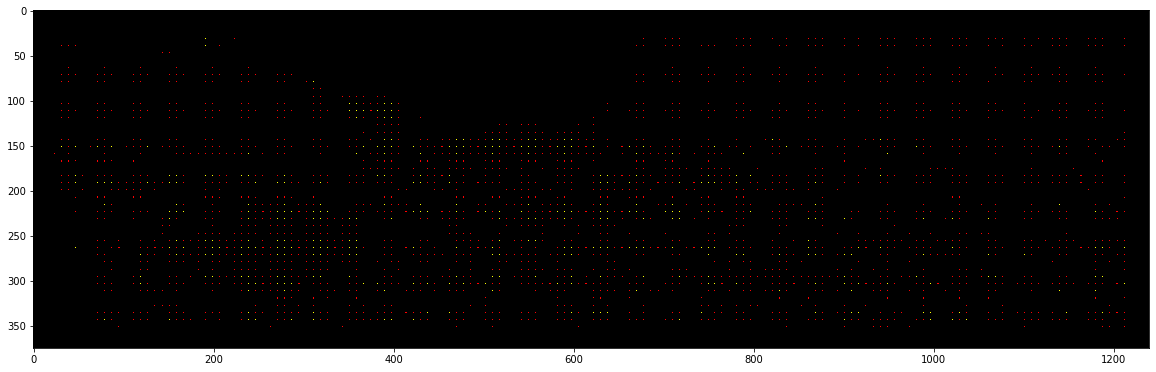

In [ ]:
from re import M
import skimage
from matplotlib import image as mpimg

matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("/content/drive/MyDrive/data_scene_flow/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

max_N = 200
counter_correct = 0
counter_total = 0
pxl_error = 3

for idx in range(max_N):
  real_disp = skimage.util.img_as_ubyte(mpimg.imread(f"/content/drive/MyDrive/data_scene_flow/disparity/{str.zfill(str(idx), 6)}_10.png"))
  real_disp = cv2.resize(real_disp, (1240, 375))

  predicted_disp = compute_disparity_map(idx, matcher)
  counter_correct += np.count_nonzero((predicted_disp != 0) & (np.abs(predicted_disp - real_disp) < pxl_error))
  counter_total += np.count_nonzero(predicted_disp)


print(f"Accuracy on KITTI: {counter_correct/counter_total}")
plot_acc_byimage(100, matcher)